In [1]:
# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipdb
import platform
import h5py
import time
import scipy.io
opj = os.path.join
deb = ipdb.set_trace
%matplotlib inline

# MRI imports
# -----------
import nibabel as nb
import cortex

cmap = 'BuBkRd'
cmap_steps = 255
vmin,vmax = -1,1

# define colormap
def get_col(data,cmap,vmin,vmax,cmap_steps):

    base = cortex.utils.get_cmap(cmap)
    val = np.linspace(0, 1,cmap_steps+1,endpoint=False)
    colmap = colors.LinearSegmentedColormap.from_list(  'my_colmap',
                                                        base(val),
                                                        N = cmap_steps)

    vrange = float(vmax) - float(vmin)
    norm_data = ((data-float(vmin))/vrange)*cmap_steps
    color_val = colmap(norm_data.astype(int))
    
    return(color_val)

In [2]:
# Define analysis parameters
# --------------------------
with open('/home/szinte/projects/retino_HCP/settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define cluster/server specific parameters
# -----------------------------------------
base_dir = analysis_info["{}_base_folder".format(platform.uname()[1])] 
base_dir_indiv = analysis_info["{}_base_folder_indiv".format(platform.uname()[1])] 
fit_model = 'gauss'            
mask_dir= 'all'

sign_idx, rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
            non_lin_idx, amp_idx, baseline_idx, cov_idx, x_idx, y_idx = 0,1,2,3,4,5,6,7,8,9,10,11

subjects =['999999','sub-01','sub-02']
for sub in analysis_info['subject_list']:subjects.append(sub)
subjects.append('sub-000')

In [3]:
pprf_rsqr_mean    = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_rsqr_std     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_rsqr_sem     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan

nprf_rsqr_mean    = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_rsqr_std     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_rsqr_sem     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan

pprf_prop           = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_prop_std       = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_prop_sem       = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan

nprf_prop           = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_prop_std       = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_prop_sem       = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan

for roi_num, roi in enumerate(analysis_info['rois']):
    for subject_num, subject in enumerate(subjects[:-1]):
        
        if subject == 'sub-01':bs_dir = base_dir_indiv
        elif subject == 'sub-02':bs_dir = base_dir_indiv
        else:bs_dir = base_dir

        h5_dir = opj(bs_dir,'pp_data',subject,fit_model,'h5')

        data_hemi = []
        for hemi in ['L', 'R']:

            folder_alias = '{hemi}_{mask_dir}'.format(hemi = hemi,mask_dir = mask_dir)
            h5_file = h5py.File(opj(h5_dir,'{roi}.h5'.format(roi = roi)), "r")
            in_file = opj("prf_deriv_{hemi}_{mask_dir}".format(hemi = hemi, mask_dir = mask_dir))
            data = h5_file['{folder_alias}/{in_file}'.format(folder_alias=folder_alias,in_file=in_file)]
            data = data[:,:].T
            data_hemi.append(data)
        
        data_LR = np.row_stack((data_hemi[0],data_hemi[1]))

        rsq_mask = data_LR[:,rsq_idx]
        rsq_mat = data_LR[:,rsq_idx]
        rsq_mat = rsq_mat[~np.isnan(rsq_mask)]
        sign_mat = data_LR[:,sign_idx]
        sign_mat = sign_mat[~np.isnan(rsq_mask)]
        pprf_rsqr = rsq_mat[sign_mat>0.0]
        nprf_rsqr = rsq_mat[sign_mat<0.0]
        nprf_rsqr = nprf_rsqr*-1.0
        
        pprf_rsqr_mean[subject_num,roi_num] = np.nanmean(pprf_rsqr,axis = 0)
        pprf_rsqr_std[subject_num,roi_num]  = np.nanstd(pprf_rsqr,axis=0,ddof=1)
        pprf_rsqr_sem[subject_num,roi_num]  = np.nanstd(pprf_rsqr,axis=0,ddof=1)/np.sqrt(pprf_rsqr.shape[0])
        
        nprf_rsqr_mean[subject_num,roi_num] = np.nanmean(nprf_rsqr,axis = 0)
        nprf_rsqr_std[subject_num,roi_num]  = np.nanstd(nprf_rsqr,axis=0,ddof=1)
        nprf_rsqr_sem[subject_num,roi_num]  = np.nanstd(nprf_rsqr,axis=0,ddof=1)/np.sqrt(nprf_rsqr.shape[0])
        
        pprf_prop[subject_num,roi_num] = np.nansum(sign_mat==1)/sign_mat.shape[0]
        nprf_prop[subject_num,roi_num] = (np.nansum(sign_mat==-1)/sign_mat.shape[0])*-1.0

In [4]:
# compute average across HCP subjects
for roi_num, roi in enumerate(analysis_info['rois']):
    pprf_rsqr_mean[-1,roi_num]      = np.nanmean(pprf_rsqr_mean[3:-1,roi_num],axis = 0)
    pprf_rsqr_std[-1,roi_num]       = np.nanstd(pprf_rsqr_mean[3:-1,roi_num],axis=0,ddof=1)
    
    nprf_rsqr_mean[-1,roi_num]      = np.nanmean(nprf_rsqr_mean[3:-1,roi_num],axis = 0)
    nprf_rsqr_std[-1,roi_num]       = np.nanstd(nprf_rsqr_mean[3:-1,roi_num],axis=0,ddof=1)

    pprf_prop[-1,roi_num]           = np.nanmean(pprf_prop[3:-1,roi_num],axis = 0)
    pprf_prop_std[-1,roi_num]       = np.nanstd(pprf_prop[3:-1,roi_num],axis=0,ddof=1)
    
    nprf_prop[-1,roi_num]           = np.nanmean(nprf_prop[3:-1,roi_num],axis = 0)
    nprf_prop_std[-1,roi_num]       = np.nanstd(nprf_prop[3:-1,roi_num],axis=0,ddof=1)

In [5]:
def plot_fig2B():
    
    all_sub2draw = [184,0,1,2]
    
    # define figure
    fig = plt.figure(figsize=(7.09*2.54, 3.75*2.54))
    grid = plt.GridSpec(6,4,hspace = 3,wspace = 0.2)

    ax0 = fig.add_subplot(grid[0:6, 0:1])
    ax0.axis('off')
    ax1 = fig.add_subplot(grid[0:2, 2])
    ax2 = fig.add_subplot(grid[0:2, 3])
    ax3 = fig.add_subplot(grid[2:4, 2])
    ax4 = fig.add_subplot(grid[2:4, 3])
    ax5 = fig.add_subplot(grid[4:6, 2])
    ax6 = fig.add_subplot(grid[4:6, 3])

    # Settings
    title_font = {'loc':'left','fontname':'Helvetica', 'fontsize':7, 'fontweight':'bold'}
    axis_tick_font = {'fontname':'Helvetica', 'fontsize':6}
    axis_label_font = {'fontname':'Helvetica', 'fontsize':7}
    
    ymin1,ymax1 = -1,1
    ymin2,ymax2 = -1,1
    ymin3,ymax3 = -1,1
    ymin4,ymax4 = -1,1
    ymin5,ymax5 = -1,1
    ymin6,ymax6 = -1,1
    y_tick_num1 = 5 
    y_tick_num2 = 5 
    y_tick_num3 = 5
    y_tick_num4 = 5
    y_tick_num5 = 5
    y_tick_num6 = 5
    
    early_vis_rois_len = np.arange(len(analysis_info['early_vis_rois']))
    late_vis_rois_len = np.arange(len(analysis_info['late_vis_rois']))
    dmn_rois_len = np.arange(len(analysis_info['dmn_rois']))
    bg_col = (0.9, 0.9, 0.9)
    axis_width = 0.75

    axs = ['ax1','ax2','ax3','ax4','ax5','ax6']

    # Titles
    ax1.set_title('Low level vision areas',**title_font)
    ax3.set_title('High level vision areas',**title_font)
    ax5.set_title('Default network areas',**title_font)

    # Remove left and top line and make axis right size
    for ax in axs:
        exec("{}.spines['top'].set_visible(False)".format(ax))
        exec("{}.spines['right'].set_visible(False)".format(ax))
        exec("{}.spines['left'].set_linewidth(axis_width)".format(ax))
        exec("{}.spines['bottom'].set_linewidth(axis_width)".format(ax))

    # Define background color
    for ax in axs:
        exec("{}.set_facecolor(bg_col)".format(ax))

    # Y lim
    ax1.set_ylim(bottom=ymin1, top=ymax1)
    ax2.set_ylim(bottom=ymin2, top=ymax2)
    ax3.set_ylim(bottom=ymin3, top=ymax3)
    ax4.set_ylim(bottom=ymin4, top=ymax4)
    ax5.set_ylim(bottom=ymin5, top=ymax5)
    ax6.set_ylim(bottom=ymin6, top=ymax6)

    # Y label
    ax1.set_ylabel('PRF R\u00b2',axis_label_font)
    ax2.set_ylabel('PRF\npolarity ratio (%)',axis_label_font)
    ax3.set_ylabel('PRF R\u00b2',axis_label_font)
    ax4.set_ylabel('PRF\npolarity ratio (%)',axis_label_font)
    ax5.set_ylabel('PRF R\u00b2',axis_label_font)
    ax6.set_ylabel('PRF\npolarity ratio (%)',axis_label_font)

    # Y Ticks
    y_tick1 = np.linspace(ymin1,ymax1,y_tick_num1)
    y_tick2 = np.linspace(ymin2,ymax2,y_tick_num2)
    y_tick3 = np.linspace(ymin3,ymax3,y_tick_num3)
    y_tick4 = np.linspace(ymin4,ymax4,y_tick_num4)
    y_tick5 = np.linspace(ymin5,ymax5,y_tick_num5)
    y_tick6 = np.linspace(ymin6,ymax6,y_tick_num6)
    ax1.set_yticks(y_tick1)
    ax2.set_yticks(y_tick2)
    ax3.set_yticks(y_tick3)
    ax4.set_yticks(y_tick4)
    ax5.set_yticks(y_tick5)
    ax6.set_yticks(y_tick6)

    # Y Tick label
    y_tick_label1 = []
    for t in zip(np.abs(y_tick1)):y_tick_label1.append('%1.2g'%t)
    y_tick_label2 = []
    for t in zip(np.abs(y_tick2)):y_tick_label2.append('%1.2g'%t)
    y_tick_label3 = []
    for t in zip(np.abs(y_tick3)):y_tick_label3.append('%1.2g'%t)
    y_tick_label4 = []
    for t in zip(np.abs(y_tick4)):y_tick_label4.append('%1.2g'%t)
    y_tick_label5 = []
    for t in zip(np.abs(y_tick5)):y_tick_label5.append('%1.2g'%t)
    y_tick_label6 = []
    for t in zip(np.abs(y_tick6)):y_tick_label6.append('%1.2g'%t)
    ax1.set_yticklabels(y_tick_label1,**axis_tick_font)
    ax2.set_yticklabels(y_tick_label2,**axis_tick_font)
    ax3.set_yticklabels(y_tick_label3,**axis_tick_font)
    ax4.set_yticklabels(y_tick_label4,**axis_tick_font)
    ax5.set_yticklabels(y_tick_label5,**axis_tick_font)
    ax6.set_yticklabels(y_tick_label6,**axis_tick_font)

    # X Ticks
    ax1.set_xticks(early_vis_rois_len)
    ax2.set_xticks(early_vis_rois_len)
    ax3.set_xticks(late_vis_rois_len)
    ax4.set_xticks(late_vis_rois_len)
    ax5.set_xticks(dmn_rois_len)
    ax6.set_xticks(dmn_rois_len)

    # X lim
    ax1.set_xlim(left=early_vis_rois_len[0]-1, right=early_vis_rois_len[-1]+1)
    ax2.set_xlim(left=early_vis_rois_len[0]-1, right=early_vis_rois_len[-1]+1)
    ax3.set_xlim(left=late_vis_rois_len[0]-1, right=late_vis_rois_len[-1]+1)
    ax4.set_xlim(left=late_vis_rois_len[0]-1, right=late_vis_rois_len[-1]+1)
    ax5.set_xlim(left=dmn_rois_len[0]-1, right=dmn_rois_len[-1]+1)
    ax6.set_xlim(left=dmn_rois_len[0]-1, right=dmn_rois_len[-1]+1)

    # X Ticks Label
    ax1.set_xticklabels(analysis_info['early_vis_rois'],**axis_tick_font,rotation = 45)
    ax2.set_xticklabels(analysis_info['early_vis_rois'],**axis_tick_font,rotation = 45)
    ax3.set_xticklabels(analysis_info['late_vis_rois'],**axis_tick_font,rotation = 45)
    ax4.set_xticklabels(analysis_info['late_vis_rois'],**axis_tick_font,rotation = 45)
    ax5.set_xticklabels(analysis_info['dmn_rois'],**axis_tick_font,rotation = 45)
    ax6.set_xticklabels(analysis_info['dmn_rois'],**axis_tick_font,rotation = 45)

    # zero lines
    line_x_early = np.arange(early_vis_rois_len[0]-1,early_vis_rois_len[-1]+2)
    line_x_late = np.arange(late_vis_rois_len[0]-1,late_vis_rois_len[-1]+2)
    line_x_dmn = np.arange(dmn_rois_len[0]-1,dmn_rois_len[-1]+2)
    ax1.plot(line_x_early,line_x_early*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax2.plot(line_x_early,line_x_early*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax3.plot(line_x_late,line_x_late*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax4.plot(line_x_late,line_x_late*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax5.plot(line_x_dmn,line_x_dmn*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax6.plot(line_x_dmn,line_x_dmn*0,color = [0.5,0.5,0.5],linewidth = axis_width)

    # text legend
    early_text_x = early_vis_rois_len[-1]+1 - (early_vis_rois_len[-1]+1)*0.05
    late_text_x = late_vis_rois_len[-1]+1 - (late_vis_rois_len[-1]+1)*0.05
    dmn_text_x = dmn_rois_len[-1]+1 - (dmn_rois_len[-1]+1)*0.05
    ax1.text(early_text_x, 0.5, 'PPRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax1.text(early_text_x, -0.5, 'NPRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax2.text(early_text_x, 0.5, 'PPRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax2.text(early_text_x, -0.5, 'NPRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax3.text(late_text_x, 0.5, 'PPRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax3.text(late_text_x, -0.5, 'NPRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax4.text(late_text_x, 0.5, 'PPRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax4.text(late_text_x, -0.5, 'NPRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax5.text(dmn_text_x, 0.5, 'PPRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax5.text(dmn_text_x, -0.5, 'NPRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax6.text(dmn_text_x, 0.5, 'PPRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax6.text(dmn_text_x, -0.5, 'NPRF', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)


    # define bar distance and width
    dist_early = 0.15 * (3.0/len(all_sub2draw))
    dist_late = len(analysis_info['late_vis_rois'])*(dist_early/len(analysis_info['early_vis_rois']))
    dist_dmn = len(analysis_info['dmn_rois'])*(dist_early/len(analysis_info['early_vis_rois']))

    width_early = 0.15 *(3.0/len(all_sub2draw))
    width_late = len(analysis_info['late_vis_rois'])*(width_early/len(analysis_info['early_vis_rois']))
    width_dmn = len(analysis_info['dmn_rois'])*(width_early/len(analysis_info['early_vis_rois']))


    # Plot all data
    # -------------
    for sub2draw_num,sub2draw in enumerate(all_sub2draw):
        if sub2draw == 1:
            rois_low   = [0,1,2,3,4,5]
            rois_high  = [6,7,8,9]
            rois_dn    = [13,14,15]
        elif sub2draw == 2:
            rois_low   = [0,1,2,3,4,5]
            rois_high  = [6,7,8,9]
            rois_dn    = [13,14,15]
        else:
            rois_low   = [0,1,2,3,4,5]
            rois_high  = [6,7,8,9,10,11,12]
            rois_dn    = [13,14,15,16]

        # PPRF/NPRF R2 x values
        ax1_x = np.arange(len(rois_low))  + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_early*(len(all_sub2draw)/3.0))
        ax3_x = np.arange(len(rois_high)) + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_late*(len(all_sub2draw)/3.0))
        ax5_x = np.arange(len(rois_dn))   + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_dmn*(len(all_sub2draw)/3.0))

        # PPRF R2
        ax1_y,ax3_y,ax5_y = pprf_rsqr_mean[sub2draw,rois_low],pprf_rsqr_mean[sub2draw,rois_high],pprf_rsqr_mean[sub2draw,rois_dn]
        ax1.bar(ax1_x,ax1_y,color = get_col(ax1_y,cmap,vmin,vmax,cmap_steps),width = width_early)
        ax3.bar(ax3_x,ax3_y,color = get_col(ax3_y,cmap,vmin,vmax,cmap_steps),width = width_late)
        ax5.bar(ax5_x,ax5_y,color = get_col(ax5_y,cmap,vmin,vmax,cmap_steps),width = width_dmn)
        if sub2draw == 184:
            ax1_yerr = pprf_rsqr_std[sub2draw,rois_low]
            ax3_yerr = pprf_rsqr_std[sub2draw,rois_high]
            ax5_yerr = pprf_rsqr_std[sub2draw,rois_dn]
            ax1.errorbar(ax1_x,ax1_y,[ax1_yerr*0,ax1_yerr], xerr=None, ecolor=get_col(ax1_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax3.errorbar(ax3_x,ax3_y,[ax3_yerr*0,ax3_yerr], xerr=None, ecolor=get_col(ax3_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax5.errorbar(ax5_x,ax5_y,[ax5_yerr*0,ax5_yerr], xerr=None, ecolor=get_col(ax5_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax1.errorbar(ax1_x,ax1_y,[ax1_yerr,ax1_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax3.errorbar(ax3_x,ax3_y,[ax3_yerr,ax3_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax5.errorbar(ax5_x,ax5_y,[ax5_yerr,ax5_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')

        # NPRF R2
        ax1_y,ax3_y,ax5_y = nprf_rsqr_mean[sub2draw,rois_low],nprf_rsqr_mean[sub2draw,rois_high],nprf_rsqr_mean[sub2draw,rois_dn]
        ax1.bar(ax1_x,ax1_y,color = get_col(ax1_y,cmap,vmin,vmax,cmap_steps),width = width_early)
        ax3.bar(ax3_x,ax3_y,color = get_col(ax3_y,cmap,vmin,vmax,cmap_steps),width = width_late)
        ax5.bar(ax5_x,ax5_y,color = get_col(ax5_y,cmap,vmin,vmax,cmap_steps),width = width_dmn)
        if sub2draw == 184:
            ax1_yerr = nprf_rsqr_std[sub2draw,rois_low]
            ax3_yerr = nprf_rsqr_std[sub2draw,rois_high]
            ax5_yerr = nprf_rsqr_std[sub2draw,rois_dn]
            ax1.errorbar(ax1_x,ax1_y,[ax1_yerr,ax1_yerr*0], xerr=None, ecolor=get_col(ax1_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax3.errorbar(ax3_x,ax3_y,[ax3_yerr,ax3_yerr*0], xerr=None, ecolor=get_col(ax3_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax5.errorbar(ax5_x,ax5_y,[ax5_yerr,ax5_yerr*0], xerr=None, ecolor=get_col(ax5_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            
            ax1.errorbar(ax1_x,ax1_y,[ax1_yerr*0,ax1_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax3.errorbar(ax3_x,ax3_y,[ax3_yerr*0,ax3_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax5.errorbar(ax5_x,ax5_y,[ax5_yerr*0,ax5_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')

        # PPRF/NPRF ratio x values
        ax2_x = np.arange(len(rois_low))  + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_early*(len(all_sub2draw)/3.0))
        ax4_x = np.arange(len(rois_high)) + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_late*(len(all_sub2draw)/3.0))
        ax6_x = np.arange(len(rois_dn))   + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_dmn*(len(all_sub2draw)/3.0))

        # PPRF ratio
        ax2_y,ax4_y,ax6_y = pprf_prop[sub2draw,rois_low],pprf_prop[sub2draw,rois_high],pprf_prop[sub2draw,rois_dn]
        ax2.bar(ax2_x,ax2_y,color = get_col(ax2_y,cmap,vmin,vmax,cmap_steps),width = width_early)
        ax4.bar(ax4_x,ax4_y,color = get_col(ax4_y,cmap,vmin,vmax,cmap_steps),width = width_late)
        ax6.bar(ax6_x,ax6_y,color = get_col(ax6_y,cmap,vmin,vmax,cmap_steps),width = width_dmn)
        if sub2draw == 184:
            ax2_yerr = pprf_prop_std[sub2draw,rois_low]
            ax4_yerr = pprf_prop_std[sub2draw,rois_high]
            ax6_yerr = pprf_prop_std[sub2draw,rois_dn]
            ax2.errorbar(ax2_x,ax2_y,[ax2_yerr*0,ax2_yerr], xerr=None, ecolor=get_col(ax2_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax4.errorbar(ax4_x,ax4_y,[ax4_yerr*0,ax4_yerr], xerr=None, ecolor=get_col(ax4_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax6.errorbar(ax6_x,ax6_y,[ax6_yerr*0,ax6_yerr], xerr=None, ecolor=get_col(ax6_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            
            ax2.errorbar(ax2_x,ax2_y,[ax2_yerr,ax2_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax4.errorbar(ax4_x,ax4_y,[ax4_yerr,ax4_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax6.errorbar(ax6_x,ax6_y,[ax6_yerr,ax6_yerr*0], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')

        # NPRF ratio
        ax2_y,ax4_y,ax6_y = nprf_prop[sub2draw,rois_low],nprf_prop[sub2draw,rois_high],nprf_prop[sub2draw,rois_dn]
        ax2.bar(ax2_x,ax2_y,color = get_col(ax2_y,cmap,vmin,vmax,cmap_steps),width = width_early)
        ax4.bar(ax4_x,ax4_y,color = get_col(ax4_y,cmap,vmin,vmax,cmap_steps),width = width_late)
        ax6.bar(ax6_x,ax6_y,color = get_col(ax6_y,cmap,vmin,vmax,cmap_steps),width = width_dmn)
        if sub2draw == 184:
            ax2_yerr = nprf_prop_std[sub2draw,rois_low]
            ax4_yerr = nprf_prop_std[sub2draw,rois_high]
            ax6_yerr = nprf_prop_std[sub2draw,rois_dn]
            ax2.errorbar(ax2_x,ax2_y,[ax2_yerr,ax2_yerr*0], xerr=None, ecolor=get_col(ax2_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax4.errorbar(ax4_x,ax4_y,[ax4_yerr,ax4_yerr*0], xerr=None, ecolor=get_col(ax4_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            ax6.errorbar(ax6_x,ax6_y,[ax6_yerr,ax6_yerr*0], xerr=None, ecolor=get_col(ax6_y,cmap,vmin,vmax,cmap_steps), elinewidth = 0.5, linestyle='none')
            
            ax2.errorbar(ax2_x,ax2_y,[ax2_yerr*0,ax2_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax4.errorbar(ax4_x,ax4_y,[ax4_yerr*0,ax4_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')
            ax6.errorbar(ax6_x,ax6_y,[ax6_yerr*0,ax6_yerr], xerr=None, ecolor=bg_col, elinewidth = 0.5, linestyle='none')

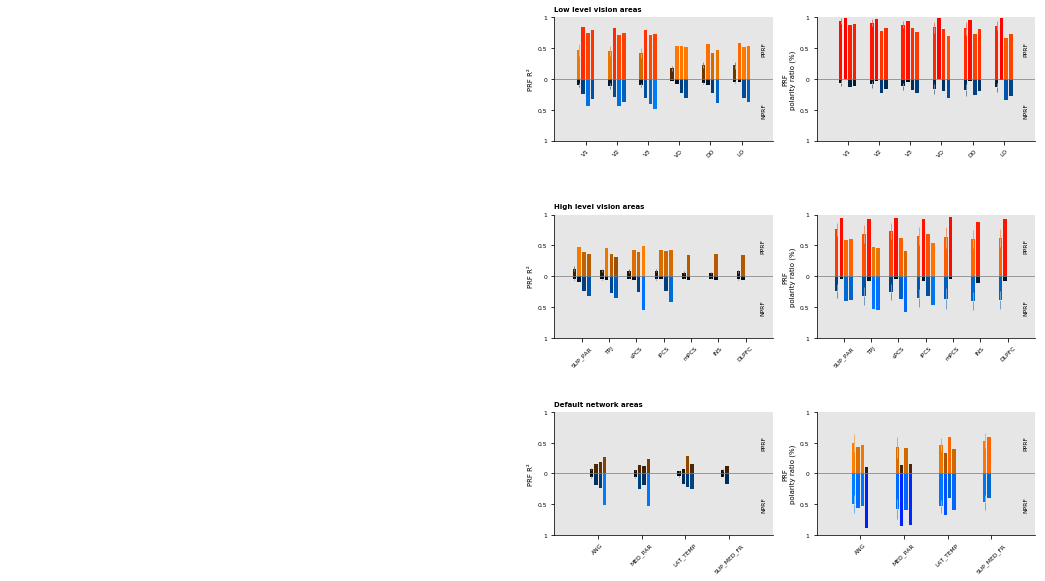

In [6]:
plot_fig2B()
img_dir = '/home/szinte/projects/retino_HCP/post_fit/notebooks/figs/Figure2/'
try: os.makedirs(img_dir)
except: pass
plt.savefig("{imdir}figure2B.pdf".format(imdir = img_dir),facecolor='w')

In [7]:
# V1 
subject2print_num = [0,1,2,184]
roi_v1 = 0
for subject_num in subject2print_num:
    if subject_num == 184:
        print("V1: {} ({}): PPPR R\u00b2 = {:1.2f} ± {:1.2f}, PPRF ratio: {:1.1f} ± {:1.1f}%".format(subjects[subject_num],
                                                                                  subject_num,
                                                                                  pprf_rsqr_mean[subject_num,roi_v1],
                                                                                  pprf_rsqr_std[subject_num,roi_v1],
                                                                                  pprf_prop[subject_num,roi_v1]*100,
                                                                                  pprf_prop_std[subject_num,roi_v1]*100))
    else:
        print("V1: {} ({}): PPPR R\u00b2 = {:1.2f}, PPRF ratio: {:1.1f}%".format( subjects[subject_num],
                                                                                  subject_num,
                                                                                  pprf_rsqr_mean[subject_num,roi_v1],
                                                                                  pprf_prop[subject_num,roi_v1]*100))

V1: 999999 (0): PPPR R² = 0.84, PPRF ratio: 99.7%
V1: sub-01 (1): PPPR R² = 0.74, PPRF ratio: 87.7%
V1: sub-02 (2): PPPR R² = 0.79, PPRF ratio: 89.0%
V1: sub-000 (184): PPPR R² = 0.47 ± 0.09, PPRF ratio: 93.8 ± 5.2%


In [8]:
# Low level visual areas PPRF
rois_low = [0,1,2,3,4,5]
for subject_num in subject2print_num:
    
    prf_r2_mean    = np.nanmean(pprf_rsqr_mean[subject_num,rois_low])
    prf_r2_std     = np.nanstd(pprf_rsqr_mean[subject_num,rois_low],axis=0,ddof=1)
    prf_prop_mean  = np.nanmean(pprf_prop[subject_num,rois_low])
    prf_prop_std   = np.nanstd(pprf_prop[subject_num,rois_low],axis=0,ddof=1)

    print("Low level visual areas: {} ({}): PPPR R\u00b2 = {:1.2f} ± {:1.2f}, PPRF ratio: {:1.1f} ± {:1.1f}%".format(   subjects[subject_num],
                                                                                                                        subject_num,
                                                                                                                        prf_r2_mean,
                                                                                                                        prf_r2_std,
                                                                                                                        prf_prop_mean*100,
                                                                                                                        prf_prop_std*100))

Low level visual areas: 999999 (0): PPPR R² = 0.69 ± 0.14, PPRF ratio: 97.6 ± 2.1%
Low level visual areas: sub-01 (1): PPPR R² = 0.61 ± 0.13, PPRF ratio: 78.0 ± 7.4%
Low level visual areas: sub-02 (2): PPPR R² = 0.63 ± 0.14, PPRF ratio: 78.7 ± 7.2%
Low level visual areas: sub-000 (184): PPPR R² = 0.33 ± 0.14, PPRF ratio: 87.6 ± 4.4%


In [9]:
# Low level visual areas NPRF
rois_low = [0,1,2,3,4,5]
for subject_num in subject2print_num:
    
    prf_r2_mean    = np.nanmean(nprf_rsqr_mean[subject_num,rois_low])
    prf_r2_std     = np.nanstd(nprf_rsqr_mean[subject_num,rois_low],axis=0,ddof=1)
    prf_prop_mean  = np.nanmean(nprf_prop[subject_num,rois_low])
    prf_prop_std   = np.nanstd(nprf_prop[subject_num,rois_low],axis=0,ddof=1)

    print("Low level visual areas: {} ({}): NPPR R\u00b2 = {:1.2f} ± {:1.2f}, NPRF ratio: {:1.1f} ± {:1.1f}%".format(   subjects[subject_num],
                                                                                                                        subject_num,
                                                                                                                        -prf_r2_mean,
                                                                                                                        prf_r2_std,
                                                                                                                        -prf_prop_mean*100,
                                                                                                                        prf_prop_std*100))

Low level visual areas: 999999 (0): NPPR R² = 0.18 ± 0.11, NPRF ratio: 2.4 ± 2.1%
Low level visual areas: sub-01 (1): NPPR R² = 0.34 ± 0.10, NPRF ratio: 22.0 ± 7.4%
Low level visual areas: sub-02 (2): NPPR R² = 0.38 ± 0.06, NPRF ratio: 21.3 ± 7.2%
Low level visual areas: sub-000 (184): NPPR R² = 0.08 ± 0.03, NPRF ratio: 12.4 ± 4.4%


In [10]:
# High level visual areas PPRF
for subject_num in subject2print_num:
    if subject_num == 1:
        rois_high = [6,7,8,9]
    elif subject_num == 2:
        rois_high = [6,7,8,9]
    else: 
        rois_high = [6,7,8,9,10,11,12]
        
    prf_r2_mean   = np.nanmean(pprf_rsqr_mean[subject_num,rois_high])
    prf_r2_std    = np.nanstd(pprf_rsqr_mean[subject_num,rois_high],axis=0,ddof=1)
    prf_prop_mean = np.nanmean(pprf_prop[subject_num,rois_high])
    prf_prop_std  = np.nanstd(pprf_prop[subject_num,rois_high],axis=0,ddof=1)
    
    print("High level visual areas: {} ({}): PPPR R\u00b3 = {:1.2f} ± {:1.2f}, PPRF ratio: {:1.1f} ± {:1.1f}%".format(  subjects[subject_num],
                                                                                                                        subject_num,
                                                                                                                        prf_r2_mean,
                                                                                                                        prf_r2_std,
                                                                                                                        prf_prop_mean*100,
                                                                                                                        prf_prop_std*100))

High level visual areas: 999999 (0): PPPR R³ = 0.41 ± 0.06, PPRF ratio: 93.1 ± 2.4%
High level visual areas: sub-01 (1): PPPR R³ = 0.39 ± 0.02, PPRF ratio: 59.2 ± 9.2%
High level visual areas: sub-02 (2): PPPR R³ = 0.40 ± 0.08, PPRF ratio: 50.4 ± 9.0%
High level visual areas: sub-000 (184): PPPR R³ = 0.08 ± 0.02, PPRF ratio: 66.7 ± 6.2%


In [11]:
# High level visual areas NPRF
for subject_num in subject2print_num:
    
    if subject_num == 1:
        rois_high = [6,7,8,9]
    elif subject_num == 2:
        rois_high = [6,7,8,9]
    else: 
        rois_high = [6,7,8,9,10,11,12]
        
    prf_r2_mean   = np.nanmean(nprf_rsqr_mean[subject_num,rois_high])
    prf_r2_std    = np.nanstd(nprf_rsqr_mean[subject_num,rois_high],axis=0,ddof=1)
    prf_prop_mean = np.nanmean(nprf_prop[subject_num,rois_high])
    prf_prop_std  = np.nanstd(nprf_prop[subject_num,rois_high],axis=0,ddof=1)
    
    print("High level visual areas: {} ({}: NPPR R\u00b3 = {:1.2f} ± {:1.2f}, NPRF ratio: {:1.1f} ± {:1.1f}%".format(   subjects[subject_num],
                                                                                                                        subject_num, 
                                                                                                                        -prf_r2_mean,
                                                                                                                        prf_r2_std,
                                                                                                                        -prf_prop_mean*100,
                                                                                                                        prf_prop_std*100))

High level visual areas: 999999 (0: NPPR R³ = 0.07 ± 0.01, NPRF ratio: 6.9 ± 2.4%
High level visual areas: sub-01 (1: NPPR R³ = 0.25 ± 0.01, NPRF ratio: 40.8 ± 9.2%
High level visual areas: sub-02 (2: NPPR R³ = 0.42 ± 0.10, NPRF ratio: 49.6 ± 9.0%
High level visual areas: sub-000 (184: NPPR R³ = 0.04 ± 0.01, NPRF ratio: 33.3 ± 6.2%


In [12]:
# Default network areas PPRF
for subject_num in subject2print_num:
    
    if subject_num == 1:
        rois_dn = [13,14,15]
    elif subject_num == 2:
        rois_dn = [13,14,15]
    else: 
        rois_dn = [13,14,15,16]
    
    prf_r2_mean   = np.nanmean(pprf_rsqr_mean[subject_num,rois_dn])
    prf_r2_std    = np.nanstd(pprf_rsqr_mean[subject_num,rois_dn],axis=0,ddof=1)
    prf_prop_mean = np.nanmean(pprf_prop[subject_num,rois_dn])
    prf_prop_std  = np.nanstd(pprf_prop[subject_num,rois_dn],axis=0,ddof=1)
    
    print("Default network areas: {} ({}): PPPR R\u00b3 = {:1.2f} ± {:1.2f}, PPRF ratio: {:1.1f} ± {:1.1f}%".format(  subjects[subject_num],
                                                                                                                      subject_num,
                                                                                                                      prf_r2_mean,
                                                                                                                      prf_r2_std,
                                                                                                                      prf_prop_mean*100,
                                                                                                                      prf_prop_std*100))

Default network areas: 999999 (0): PPPR R³ = 0.12 ± 0.04, PPRF ratio: 37.5 ± 18.9%
Default network areas: sub-01 (1): PPPR R³ = 0.20 ± 0.08, PPRF ratio: 49.2 ± 9.8%
Default network areas: sub-02 (2): PPPR R³ = 0.22 ± 0.05, PPRF ratio: 22.4 ± 15.8%
Default network areas: sub-000 (184): PPPR R³ = 0.05 ± 0.01, PPRF ratio: 48.1 ± 4.5%


In [13]:
# Default network areas NPRF
for subject_num in subject2print_num:
    
    if subject_num == 1:
        rois_dn = [13,14,15]
    elif subject_num == 2:
        rois_dn = [13,14,15]
    else: 
        rois_dn = [13,14,15,16]
        
    prf_r2_mean   = np.nanmean(nprf_rsqr_mean[subject_num,rois_dn])
    prf_r2_std    = np.nanstd(nprf_rsqr_mean[subject_num,rois_dn],axis=0,ddof=1)
    prf_prop_mean = np.nanmean(nprf_prop[subject_num,rois_dn])
    prf_prop_std  = np.nanstd(nprf_prop[subject_num,rois_dn],axis=0,ddof=1)
    
    print("Default network areas: {} ({}): NPPR R\u00b3 = {:1.2f} ± {:1.2f}, NPRF ratio: {:1.1f} ± {:1.1f}%".format(  subjects[subject_num],
                                                                                                                      subject_num,
                                                                                                                      -prf_r2_mean,
                                                                                                                      prf_r2_std,
                                                                                                                      -prf_prop_mean*100,
                                                                                                                      prf_prop_std*100))

Default network areas: 999999 (0): NPPR R³ = 0.20 ± 0.04, NPRF ratio: 62.5 ± 18.9%
Default network areas: sub-01 (1): NPPR R³ = 0.21 ± 0.03, NPRF ratio: 50.8 ± 9.8%
Default network areas: sub-02 (2): NPPR R³ = 0.43 ± 0.15, NPRF ratio: 77.6 ± 15.8%
Default network areas: sub-000 (184): NPPR R³ = 0.05 ± 0.01, NPRF ratio: 51.9 ± 4.5%


In [14]:
# Default network araeas NPRF
for subject_num in subject2print_num:

    if subject_num == 1:
        rois_dn = [13,14,15]
    elif subject_num == 2:
        rois_dn = [13,14,15]
    else: 
        rois_dn = [13,14,15,16]


    for roi_num in rois_dn:
        if subject_num == 184:
            print("{}: {} ({}): NPPR R\u00b2 = {:1.2f} ± {:1.2f}, NPRF ratio: {:1.1f} ± {:1.2f}%".format(analysis_info['rois'][roi_num],
                                                                                                         subjects[subject_num],
                                                                                                         subject_num,
                                                                                                         -nprf_rsqr_mean[subject_num,roi_num],
                                                                                                         nprf_rsqr_std[subject_num,roi_num],
                                                                                                         -nprf_prop[subject_num,roi_num]*100,
                                                                                                         nprf_prop_std[subject_num,roi_num]*100))
        else:
            print("{}: {} ({}): NPPR R\u00b2 = {:1.2f}, NPRF ratio: {:1.1f}%".format(analysis_info['rois'][roi_num],
                                                                                     subjects[subject_num],
                                                                                     subject_num,
                                                                                     -nprf_rsqr_mean[subject_num,roi_num],
                                                                                     -nprf_prop[subject_num,roi_num]*100))
    print('')

ANG: 999999 (0): NPPR R² = 0.19, NPRF ratio: 56.6%
MED_PAR: 999999 (0): NPPR R² = 0.25, NPRF ratio: 85.5%
LAT_TEMP: 999999 (0): NPPR R² = 0.18, NPRF ratio: 67.4%
SUP_MED_FR: 999999 (0): NPPR R² = 0.18, NPRF ratio: 40.6%

ANG: sub-01 (1): NPPR R² = 0.24, NPRF ratio: 53.1%
MED_PAR: sub-01 (1): NPPR R² = 0.18, NPRF ratio: 59.3%
LAT_TEMP: sub-01 (1): NPPR R² = 0.22, NPRF ratio: 40.0%

ANG: sub-02 (2): NPPR R² = 0.51, NPRF ratio: 88.9%
MED_PAR: sub-02 (2): NPPR R² = 0.54, NPRF ratio: 84.2%
LAT_TEMP: sub-02 (2): NPPR R² = 0.26, NPRF ratio: 59.5%

ANG: sub-000 (184): NPPR R² = 0.06 ± 0.02, NPRF ratio: 49.9 ± 14.69%
MED_PAR: sub-000 (184): NPPR R² = 0.06 ± 0.01, NPRF ratio: 57.5 ± 16.57%
LAT_TEMP: sub-000 (184): NPPR R² = 0.04 ± 0.01, NPRF ratio: 53.4 ± 10.77%
SUP_MED_FR: sub-000 (184): NPPR R² = 0.05 ± 0.01, NPRF ratio: 47.0 ± 12.20%



In [15]:
def bootstrap(data,ni):
    nc = data.shape[0]
    bsData = np.ones((ni,data.shape[1]))*np.nan
    for i in np.arange(ni):
        bsSample = np.random.choice(np.arange(nc), nc, True)
        bsData[i,:] = np.mean(data[bsSample,:],axis=0);
        
    return bsData

def comp_bootstrap(meanRes,bootMat,compVal,bilateral = True):

    num_boot = bootMat.shape[0]
    
    diff_bt = bootMat[:,compVal[0]] - bootMat[:,compVal[1]]
    diff_mean = meanRes[compVal[0]] - meanRes[compVal[1]]
    if diff_mean < 0:       pVal_comp = np.sum(diff_bt>0)/num_boot
    elif diff_mean > 0:     pVal_comp = 1-np.sum(diff_bt>0)/num_boot
    elif diff_mean == 0:    pVal_comp = 1;

    if bilateral == True:
        pVal_comp = pVal_comp*2;
    
    if pVal_comp == 0:      pVal_comp = 1/num_boot
    elif pVal_comp > 1:     pVal_comp = 1

    return pVal_comp

In [16]:
num_bootstrap = 10000

rois_low = [0,1,2,3,4,5]
rois_high = [6,7,8,9,10,11,12]
rois_dn = [13,14,15,16]

early_prf_r2_mean    = np.nanmean(pprf_rsqr_mean[3:-1,rois_low],axis = 1)
early_prf_prop_mean  = np.nanmean(pprf_prop[3:-1,rois_low],axis = 1)

late_prf_r2_mean    = np.nanmean(pprf_rsqr_mean[3:-1,rois_high],axis = 1)
late_prf_prop_mean  = np.nanmean(pprf_prop[3:-1,rois_high],axis = 1)

dn_prf_r2_mean    = np.nanmean(nprf_rsqr_mean[3:-1,rois_dn],axis = 1)
dn_prf_prop_mean  = np.nanmean(nprf_prop[3:-1,rois_dn],axis = 1)

matRes = np.array([early_prf_r2_mean,early_prf_prop_mean,late_prf_r2_mean,late_prf_prop_mean,-dn_prf_r2_mean,-dn_prf_prop_mean]).T
mean_matRes = np.nanmean(matRes,axis=0)
std_matRes = np.nanstd(matRes,axis=0,ddof=1)
bootMat = bootstrap(matRes,num_bootstrap)

In [17]:
# comparison low/high PPRF R2 mean
pprf_rsqr_mean_compVal = [0,2]
pprf_rsqr_mean_pVal = comp_bootstrap(mean_matRes,bootMat,pprf_rsqr_mean_compVal,True)

print("Low vs. High level visual areas: PPPR R\u00b2 = {:1.2f} ± {:1.2f} vs. {:1.2f} ± {:1.2f}, p < {:1.4f}".format(mean_matRes[pprf_rsqr_mean_compVal[0]],
                                                                                                                   std_matRes[pprf_rsqr_mean_compVal[0]],
                                                                                                                   mean_matRes[pprf_rsqr_mean_compVal[1]],
                                                                                                                   std_matRes[pprf_rsqr_mean_compVal[1]],
                                                                                                                   pprf_rsqr_mean_pVal))

Low vs. High level visual areas: PPPR R² = 0.33 ± 0.06 vs. 0.08 ± 0.02, p < 0.0001


In [18]:
# comparison low/high PPRF polarity ratio
prf_prop_mean_compVal = [1,3]
prf_prop_mean_pVal = comp_bootstrap(mean_matRes,bootMat,prf_prop_mean_compVal,True)
print("Low vs. High level visual areas: PPRF ratio: {:1.1f} ± {:1.2f}% vs. {:1.1f} ± {:1.2f} %, p < {:1.4f}".format(mean_matRes[prf_prop_mean_compVal[0]]*100,
                                                                                                                    std_matRes[prf_prop_mean_compVal[0]]*100,
                                                                                                                    mean_matRes[prf_prop_mean_compVal[1]]*100,
                                                                                                                    std_matRes[prf_prop_mean_compVal[1]]*100,
                                                                                                                    prf_prop_mean_pVal))

Low vs. High level visual areas: PPRF ratio: 87.6 ± 5.41% vs. 66.7 ± 12.64 %, p < 0.0001


In [19]:
# comparison dn/low PPRF R2 mean
pprf_rsqr_mean_compVal = [0,4]
pprf_rsqr_mean_pVal = comp_bootstrap(mean_matRes,bootMat,prf_prop_mean_compVal,True)

print("Low level visual vs. default network areas: PPPR R\u00b2 = {:1.2f} ± {:1.2f} vs. {:1.2f} ± {:1.2f}, p < {:1.4f}".format(mean_matRes[pprf_rsqr_mean_compVal[0]],
                                                                                                                   std_matRes[pprf_rsqr_mean_compVal[0]],
                                                                                                                   mean_matRes[pprf_rsqr_mean_compVal[1]],
                                                                                                                   std_matRes[pprf_rsqr_mean_compVal[1]],
                                                                                                                   pprf_rsqr_mean_pVal))



Low level visual vs. default network areas: PPPR R² = 0.33 ± 0.06 vs. 0.05 ± 0.01, p < 0.0001


In [20]:
# comparison high/low PPRF R2 mean
pprf_rsqr_mean_compVal = [2,4]
pprf_rsqr_mean_pVal = comp_bootstrap(mean_matRes,bootMat,prf_prop_mean_compVal,True)

print("High level visual vs. default network areas: PPPR R\u00b2 = {:1.2f} ± {:1.2f} vs. {:1.2f} ± {:1.2f}, p < {:1.4f}".format(mean_matRes[pprf_rsqr_mean_compVal[0]],
                                                                                                                   std_matRes[pprf_rsqr_mean_compVal[0]],
                                                                                                                   mean_matRes[pprf_rsqr_mean_compVal[1]],
                                                                                                                   std_matRes[pprf_rsqr_mean_compVal[1]],
                                                                                                                   pprf_rsqr_mean_pVal))

High level visual vs. default network areas: PPPR R² = 0.08 ± 0.02 vs. 0.05 ± 0.01, p < 0.0001
